In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.applications import vgg16 ,resnet50 ,xception ,inception_v3 ,inception_resnet_v2 ,resnet_v2 ,nasnet
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate ,Dense ,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing

import os
import zipfile    #Unzip  data
import shutil     #Manipulate data in disk
from tqdm import tqdm   #Gives indication of how much for loop progressed

## Data preparation


In [7]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('test/images')

In [8]:
df = pd.read_csv('../input/dog-breed-identification/labels.csv')
breeds  = list(df['breed'])       #list of training examples breeds
s_breed = df['breed']
unq_breed = s_breed.unique()      #All 120 breeds
id = list(df['id'])               #list of trainig examples id

In [9]:
#make a directory for each breed in the training directory
for breed in list(unq_breed):
  os.mkdir('train/' + breed)

In [10]:
#make a function that moves all training images to a breed directory according to thier label
#If image labeled as 'Boston bull' it will move to the 'train/boston_bull' directory 
def move_train_images(breeds , ids ,image_path):
  lst = os.listdir(image_path)
  for name in tqdm(lst):
    for i , id in enumerate(ids):
      if name.split('.')[0] == id:
        shutil.copy(image_path + name , 'train/' + breeds[i])

In [11]:
move_train_images(breeds , id , '../input/dog-breed-identification/train/')

#since test data is not labeled, all images will be moved in 'test/images' directory
for img in tqdm(os.listdir('../input/dog-breed-identification/test/')):
  shutil.copy('../input/dog-breed-identification/test/' + img , './test/images')

100%|██████████| 10357/10357 [00:46<00:00, 223.46it/s]


In [12]:
train_dir = './train'
test_dir = './test'

#read csv data
train_labels = pd.read_csv('../input/dog-breed-identification/labels.csv', index_col = 'id')
submission=pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [13]:
train_size = len(os.listdir(train_dir))
test_size = len(os.listdir(test_dir))

print(train_size,test_size)
print(train_labels.shape)
print(submission.shape)

120 1
(10222, 1)
(10357, 121)


In [14]:
train_labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [15]:
n_epochs = 50
batch_size = 128
img_height = 331
img_width= 331

## Prepare the Datasets

In [16]:
train_ds = image_dataset_from_directory(
  directory = train_dir,
  labels = 'inferred',
  label_mode='int',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle = True,
  seed=17,
  validation_split=0.1,
  subset="training",
)

Found 10222 files belonging to 120 classes.
Using 9200 files for training.


2022-11-15 12:25:00.060876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:25:00.209980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:25:00.210761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 12:25:00.214300: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
val_ds = image_dataset_from_directory(
  directory = train_dir,
  labels = 'inferred',
  label_mode='int',
  batch_size=batch_size,
  image_size=(img_height,img_width),
  shuffle = True,
  seed=17,
  validation_split=0.1,
  subset="validation",
)

Found 10222 files belonging to 120 classes.
Using 1022 files for validation.


In [18]:
test_ds = image_dataset_from_directory(
  directory = test_dir,
  label_mode= None,
  batch_size=batch_size,
  image_size=(img_height,img_height),
  shuffle = False,
  seed=1234
)

Found 10357 files belonging to 1 classes.


## Optimize the dataset for performance

here is a to do list to optimize the [data_performance](https://www.tensorflow.org/guide/data_performance)

We will use only one method:

[.prefetch()](https://www.tensorflow.org/guide/data_performance#prefetching) overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation layer

In [20]:
data_augmentation = Sequential(
  [
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
  ]
)

## Build a Model

In [22]:
base_model_1 = xception.Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))

base_model_2 = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))

base_model_3 = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))

#base_model_4 = resnet_v2.ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

base_model_5 = nasnet.NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))

# train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
base_model_1.trainable = False
base_model_2.trainable = False
base_model_3.trainable = False
# base_model_4.trainable = False
base_model_5.trainable = False

inputs = Input(shape=(img_height,img_width, 3))
aug_inputs = data_augmentation(inputs)

## <-----  Xception   -----> ##
x1 = xception.preprocess_input(aug_inputs)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here by passing `training=False`.
x1 = base_model_1(x1, training=False)
x1 = GlobalAveragePooling2D()(x1)

## <-----  InceptionV3   -----> ##
x2 = inception_v3.preprocess_input(aug_inputs)
x2 = base_model_2(x2, training=False)
x2 = GlobalAveragePooling2D()(x2)


## <-----  NASNetLarge   -----> ##
x5 = nasnet.preprocess_input(aug_inputs)
x5 = base_model_5(x5, training=False)
x5 = GlobalAveragePooling2D()(x5)

## <-----  Concatenation  -----> ##
x = Concatenate()([x1, x2, x5])
x = Dropout(.7)(x)
outputs = Dense(120, activation='softmax')(x)
model = Model(inputs, outputs)

display(model.summary())

343621632/343610240 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 331, 331, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 331, 331, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
tf.math.truediv_1 (TFOpLambda)  (None, 331, 331, 3)  0           sequential[0][0]                 
__________________________

None

## Training the Model

In [23]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)

In [24]:
EarlyStop_callback = EarlyStopping(min_delta=0.001, patience=12, restore_best_weights=True)

In [25]:
history = model.fit(
    train_ds,
    epochs=n_epochs,
    validation_data=val_ds,
    callbacks=[EarlyStop_callback]
)

Epoch 1/50


2022-11-15 12:28:49.145367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-15 12:28:56.371848: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.7641

2022-11-15 12:33:19.958209: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.98GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


72/72 [==============================] - 295s 4s/step - loss: 1.1944 - accuracy: 0.7641 - val_loss: 0.2090 - val_accuracy: 0.9344
Epoch 2/50
72/72 [==============================] - 248s 3s/step - loss: 0.2926 - accuracy: 0.9109 - val_loss: 0.1944 - val_accuracy: 0.9344
Epoch 3/50
72/72 [==============================] - 248s 3s/step - loss: 0.2426 - accuracy: 0.9234 - val_loss: 0.1910 - val_accuracy: 0.9384
Epoch 4/50
72/72 [==============================] - 247s 3s/step - loss: 0.2230 - accuracy: 0.9287 - val_loss: 0.1962 - val_accuracy: 0.9364
Epoch 5/50
72/72 [==============================] - 247s 3s/step - loss: 0.1904 - accuracy: 0.9389 - val_loss: 0.1962 - val_accuracy: 0.9403
Epoch 7/50
72/72 [==============================] - 247s 3s/step - loss: 0.1665 - accuracy: 0.9449 - val_loss: 0.1960 - val_accuracy: 0.9393
Epoch 8/50
72/72 [==============================] - 247s 3s/step - loss: 0.1557 - accuracy: 0.9455 - val_loss: 0.1970 - val_accuracy: 0.9432
Epoch 9/50
72/72 [======

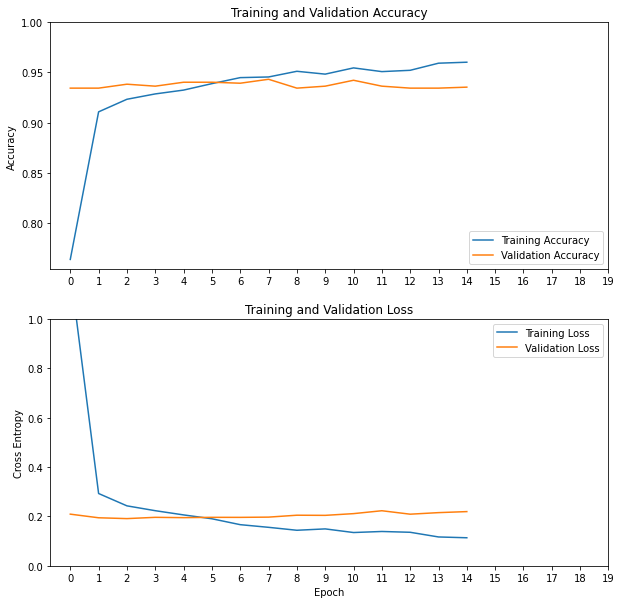

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xticks(list(range(20)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xticks(list(range(20)))
plt.xlabel('Epoch')
plt.show()

## Predict on Test Dataset

In [27]:
target, dog_breeds = pd.factorize(train_labels['breed'], sort = True)
train_labels['target'] = target

In [28]:
predictions = model.predict(
    test_ds,
    batch_size =batch_size,
    verbose=1         
)

81/81 [==============================] - 249s 3s/step


In [31]:
print(predictions.shape)
print(predictions)

(10357, 120)
[[1.5736360e-06 2.9990508e-06 1.5115451e-06 ... 7.7903604e-07
  1.5938415e-06 3.6022468e-06]
 [1.2331795e-06 7.7855424e-07 7.1358295e-07 ... 7.0895140e-07
  1.2842767e-06 4.5279676e-06]
 [2.9470164e-06 2.1074376e-04 3.0798801e-05 ... 5.8350424e-06
  5.8710680e-06 2.9427631e-05]
 ...
 [8.5436352e-07 6.4865430e-06 2.2554930e-04 ... 2.4345750e-06
  3.1503218e-06 6.5937325e-06]
 [2.1470401e-05 8.5645843e-06 5.7894586e-06 ... 4.5545457e-06
  3.4415270e-06 7.8192068e-05]
 [4.9090268e-06 3.1044742e-04 8.2368977e-05 ... 5.4581871e-04
  2.6935946e-05 1.4232321e-05]]


## Submission

In [33]:
submission.loc[:, dog_breeds] = predictions
submission
submission.to_csv('submission.csv', index=False)